In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# import own modules
repo_name = 'pinpointing-radio-devices'
module_path = os.getcwd()[:os.getcwd().find(repo_name)+len(repo_name)]
sys.path.append(os.path.abspath(module_path))

import src.data_utils as du
from src.data_utils import AP_IDXS, RF_IDXS, AGV_SPEED

In [ ]:
DATA_PATH = r"data"
round_idxs = pd.read_csv(os.path.join(module_path, "round_idxs.csv"))["round_idxs"].values

In [3]:
COLUMN_WIDTH = 3.8
TEXT_WIDTH = 7.19
FONT_SIZE = 8
DPI = 600
PAD_INCHES = 0.01

plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams["mathtext.fontset"] = "stix"

## Plot wideband and subchannels channel gain

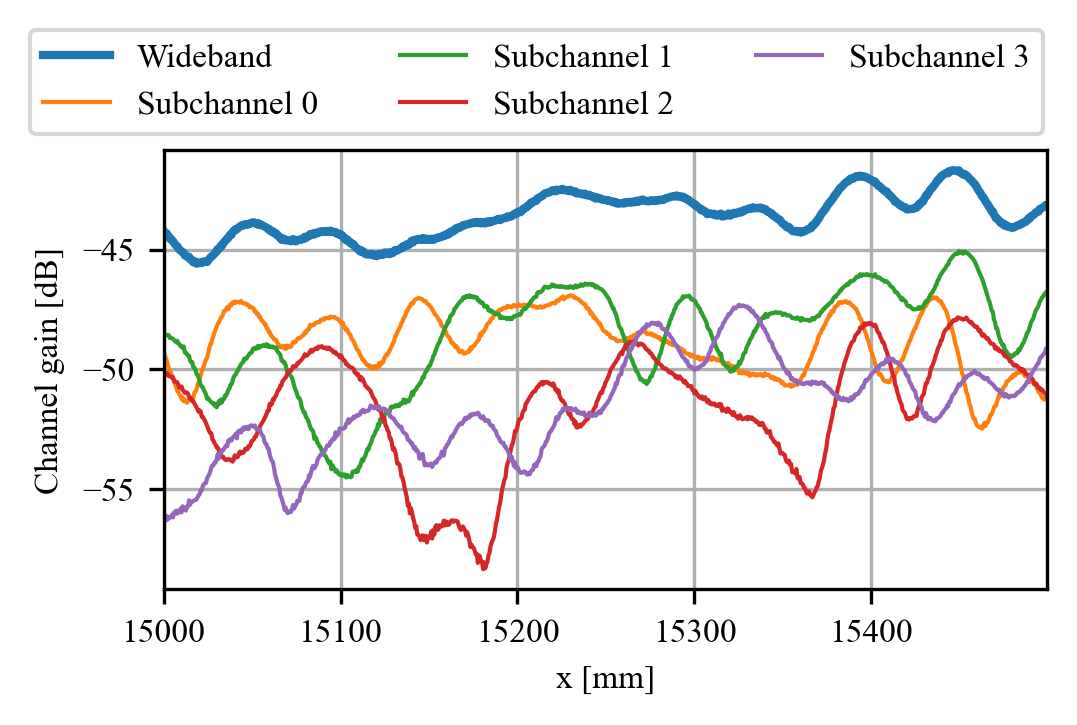

In [4]:
round_nr = 0

data_wb = du.load_one_round(DATA_PATH, round_idxs[round_nr], AP_IDXS, RF_IDXS, 1)
data_4sc = du.load_one_round(DATA_PATH, round_idxs[round_nr], AP_IDXS, RF_IDXS, 4)

# smooth the data
sequence_length = 1
interval = 1
data_wb = du.smooth_round(data_wb, sequence_length, 1, interval)
data_4sc = du.smooth_round(data_4sc, sequence_length, 1, interval)

x_start = 15  # in m
x_len = 0.5  # in m

start_idx = int(x_start * 1e3 / AGV_SPEED)
num_samples_plot = int(x_len * 1e3 / AGV_SPEED)

x = np.arange(start_idx, start_idx + num_samples_plot) * AGV_SPEED


plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH * 1 / 2), dpi=DPI // 2)
plt.plot(
    x,
    data_wb[start_idx : start_idx + num_samples_plot, 0, 0, 0],
    lw=2,
    label="Wideband",
)

for sc_idx in range(4):
    plt.plot(
        x,
        data_4sc[start_idx : start_idx + num_samples_plot, 0, 0, sc_idx],
        lw=1,
        label=f"Subchannel {sc_idx}",
    )

plt.xlim(x[0], x[-1])
plt.legend(ncol=3, bbox_to_anchor=(-0.17, 1.0, 1, 0), columnspacing=2.45)
plt.grid()
plt.xlabel("x [mm]")
plt.ylabel("Channel gain [dB]")

plt.savefig(
    os.path.join(module_path, "figures", "channel_gain_wb_and_sc.pdf"),
    bbox_inches="tight",
    dpi=DPI,
    pad_inches=PAD_INCHES,
)


## Plot Channel Gain for Several Rounds

Plotting rounds:   0%|          | 0/37 [00:00<?, ?it/s]

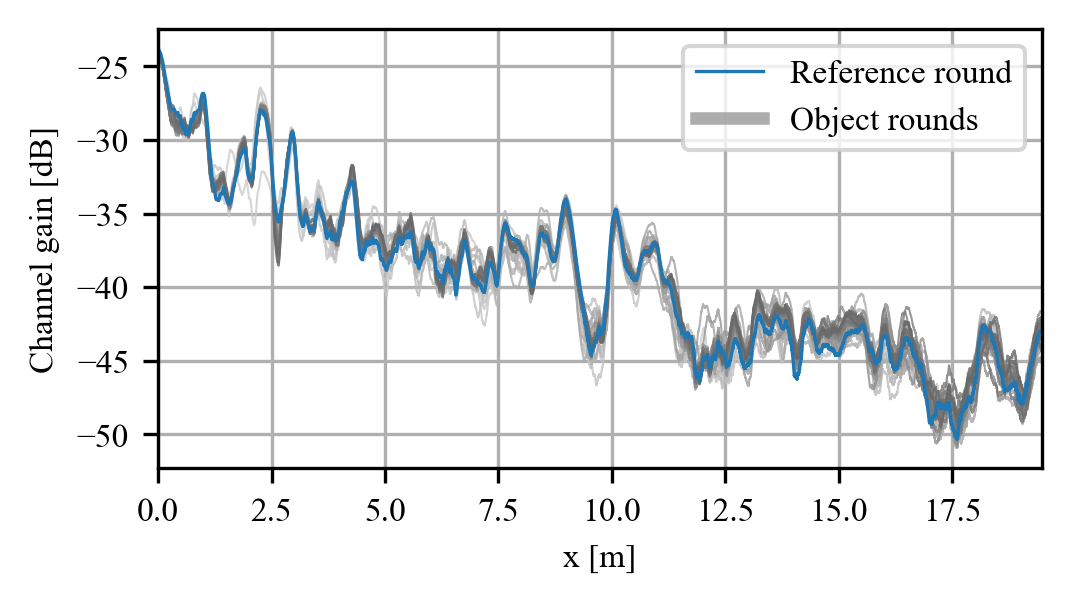

In [5]:
round_idxs = pd.read_csv(os.path.join("..", "round_idxs.csv"))["round_idxs"].values

ap_idx = 0
rf_idx = 0


sequence_length = 267
interval = 33

def load_and_smooth_round(round_idx):
    data = du.load_one_round(DATA_PATH, round_idx, du.AP_IDXS, du.RF_IDXS, 1)
    data = du.smooth_round(data, sequence_length, 1, interval)
    return data


data_ref = load_and_smooth_round(round_idxs[0])

start_idx = 0
end_idx = start_idx + len(data_ref)
x = np.arange(0, (end_idx-start_idx) * AGV_SPEED, AGV_SPEED)
x = x / 1000 # convert to m

c = np.ones(3) * 0.8  # start color, dark grey
c_end = np.ones(3) * 0.4  # end color, light grey
c_step = (c_end - c) / len(round_idxs[1:])

plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH * 1/2), dpi=DPI//2)

for round_idx in tqdm(round_idxs[1::], desc="Plotting rounds"):
    data = load_and_smooth_round(round_idx)
    plt.plot(x, data[start_idx:end_idx, ap_idx, rf_idx, 0, 0], lw=0.5, color=c.copy(), alpha=0.8)
    c += c_step

# plot the reference last to have it on top
plt.plot(x, data_ref[start_idx:end_idx, ap_idx, rf_idx, 0, 0], lw=0.8, label="Reference round")

# for the legend entry
plt.plot([], [], lw=3, color=0.6 * np.ones(3), alpha=0.8, label="Object rounds")

plt.xlim(x[0], x[-1])
plt.grid()
plt.xlabel("x [m]")
plt.ylabel("Channel gain [dB]")
plt.legend()

plt.savefig(
    os.path.join(module_path, "figures", f"channel_gain_several_rounds_ap{ap_idx}_rf{rf_idx}.pdf"),
    bbox_inches='tight',
    dpi=DPI,
    pad_inches=PAD_INCHES,
)


## Analyze the Impact of Interval Sizes

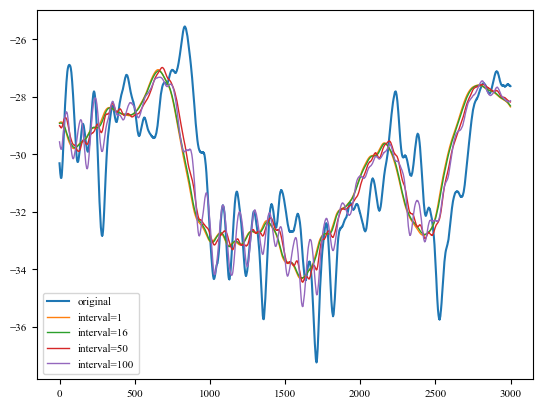

In [6]:
round_nr = 10

data_wb = du.load_one_round(DATA_PATH, round_idxs[round_nr], AP_IDXS, RF_IDXS, 1)

seq_len = 250
intervals = [1, 16, 50, 100]

data_smoothed = {}
for interval in intervals:
    data_smoothed[interval] = du.smooth_round(data_wb, seq_len, stride=interval, num_timesteps=1)

plot_idx_start = 1000
num_samples_plot = 3000
plt.plot(data_wb[plot_idx_start:plot_idx_start+num_samples_plot, 0, 0, 0], label="original")
for interval in intervals:
    plt.plot(data_smoothed[interval][plot_idx_start:plot_idx_start+num_samples_plot, 0, 0, 0], lw=1, label=f"interval={interval}")
plt.legend()


## Check Timesteps Implementation

In [7]:
num_timesteps_list = [1, 2, 5]
data_smoothed = {}
for num_timesteps in num_timesteps_list:
    data_smoothed[num_timesteps] = du.smooth_round(data_wb, seq_len, stride=16, num_timesteps=num_timesteps)

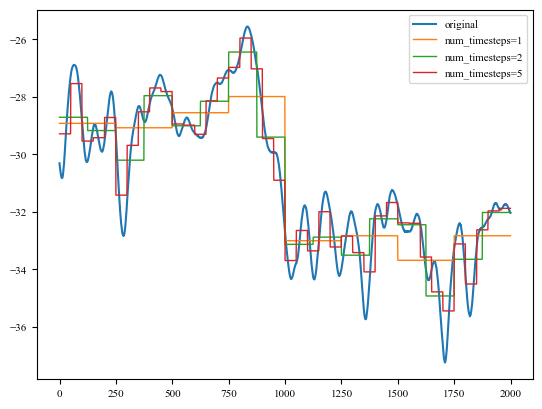

In [8]:
plot_idx_start = 1000
num_samples_plot = 2000
plt.plot(data_wb[plot_idx_start:plot_idx_start+num_samples_plot, 0, 0, 0], label="original")
for num_timesteps in num_timesteps_list:
    plot_values = np.zeros(num_samples_plot)

    subseq_len = seq_len // num_timesteps
    for i in range(plot_idx_start, plot_idx_start+num_samples_plot, seq_len):
        for ts in range(num_timesteps):
            subseq_start_idx = i + ts * subseq_len - plot_idx_start
            plot_values[subseq_start_idx:subseq_start_idx+subseq_len] = data_smoothed[num_timesteps][i, 0, 0, 0, ts] * np.ones(subseq_len)

    plt.plot(plot_values, lw=1, label=f"num_timesteps={num_timesteps}")

plt.legend()
